In [ ]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
import random
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = '/content/drive/My Drive/Colab Notebooks/data.zip'

extract_path = '/content/drive/My Drive/Colab Notebooks/data'

shutil.unpack_archive(zip_path, extract_path)

**Exercise 12**

Randomly select  150  images of cats,  150  images of dogs, and  150  images of snakes. Set these aside in another directory labeled test_images to be your testing set. Using the same approach, randomly select another  150  images from each class, and set these aside in a validation_images directory to be your validation set.

In [ ]:
base_dir = '/content/drive/My Drive/Colab Notebooks/data/data/Animals'

test_dir = '/content/drive/My Drive/Colab Notebooks/data/test_images'
validation_dir = '/content/drive/My Drive/Colab Notebooks/data/validation_images'
train_dir = '/content/drive/My Drive/Colab Notebooks/data/train_images'

classes = ['cats', 'dogs', 'snakes']

for directory in [test_dir, validation_dir, train_dir]:
    os.makedirs(directory, exist_ok=True)
    for class_name in classes:
        os.makedirs(os.path.join(directory, class_name), exist_ok=True)

In [ ]:
def select_and_move_images(source_dir, target_dir, classes, num_images):
    for class_name in classes:
        target_class_dir = os.path.join(target_dir, class_name)

        # Check if the target class directory already contains images
        if os.path.exists(target_class_dir) and any(img.endswith('.jpg') for img in os.listdir(target_class_dir)):
            continue

    for class_name in classes:
        target_class_dir = os.path.join(target_dir, class_name)

        if not os.path.exists(target_class_dir) or not any(img.endswith('.jpg') for img in os.listdir(target_class_dir)):
            source_class_dir = os.path.join(source_dir, class_name)
            os.makedirs(target_class_dir, exist_ok=True)

            images = [img for img in os.listdir(source_class_dir) if img.endswith('.jpg')]
            selected_images = random.sample(images, num_images)

            for image in selected_images:
                shutil.move(os.path.join(source_class_dir, image), os.path.join(target_class_dir, image))


In [ ]:
num_images = 150
# test
select_and_move_images(base_dir, test_dir, classes, num_images)
# validation
select_and_move_images(base_dir, validation_dir, classes, num_images)

In [ ]:
def move_remaining_to_train(source_dir, train_dir, classes):
    for class_name in classes:
        source_class_dir = os.path.join(source_dir, class_name)
        train_class_dir = os.path.join(train_dir, class_name)

        images = [img for img in os.listdir(source_class_dir) if img.endswith('.jpg')]

        for image in images:
            shutil.move(os.path.join(source_class_dir, image), os.path.join(train_class_dir, image))

move_remaining_to_train(base_dir, train_dir, classes)

In [ ]:
def count_images(directory, classes):
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        print(f"{class_name}: {len(os.listdir(class_dir))} images")

print("Test set:")
count_images(test_dir, classes)

print("Validation set:")
count_images(validation_dir, classes)

print("Train set:")
count_images(train_dir, classes)

Test set:
cats: 150 images
dogs: 150 images
snakes: 150 images
Validation set:
cats: 150 images
dogs: 150 images
snakes: 150 images
Train set:
cats: 700 images
dogs: 700 images
snakes: 700 images


**Exercise 13**

Display a random image from each of the three classes in your training set to verify that the data are set up correctly.


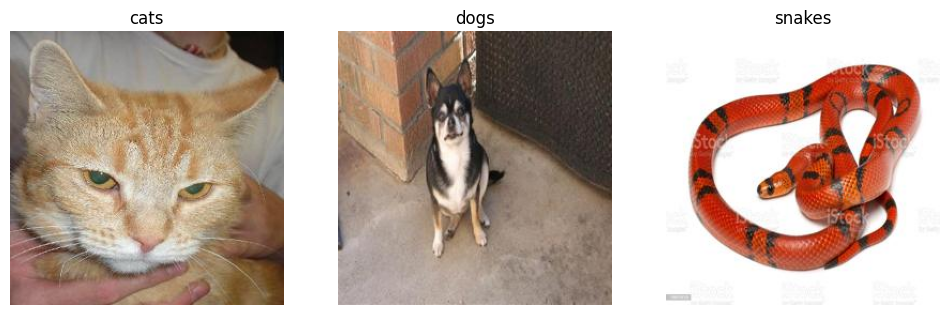

In [ ]:


classes = ['cats', 'dogs', 'snakes']

def plot_images(train_dir, classes):
    plt.figure(figsize=(12, 12))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(train_dir, class_name)

        images = [img for img in os.listdir(class_dir) if img.endswith('.jpg')]

        random_image = random.choice(images)

        img_path = os.path.join(class_dir, random_image)
        img = image.load_img(img_path, target_size=(256, 256))
        img_array = image.img_to_array(img)

        plt.subplot(1, len(classes), i+1)
        plt.imshow(img_array.astype('uint8'))
        plt.title(class_name)
        plt.axis('off')  # Turn off axis

    plt.show()

plot_images(train_dir, classes)

**Exercise 14**

Using ImageDataGenerator and flow_from_directory, rescale your training, testing, and validation sets. Load and preprocess your images in batches of size  10 .

In [ ]:
# Training set
train_gen = ImageDataGenerator(rescale = 1.0/255.0) # scale the data
train_image_generator = train_gen.flow_from_directory(train_dir,
                                                      target_size=(150, 150),
                                                      batch_size=10,
                                                      class_mode='categorical')

# Validation set
val_gen = ImageDataGenerator(rescale = 1.0/255.0) # scale the data
val_image_generator = train_gen.flow_from_directory(validation_dir,
                                                    target_size=(150, 150),
                                                    batch_size=10,
                                                    class_mode='categorical')

# Testing set
test_gen = ImageDataGenerator(rescale = 1.0/255.0) # scale the data
test_image_generator = train_gen.flow_from_directory(test_dir,
                                                     target_size=(150, 150),
                                                     batch_size=10,
                                                     class_mode='categorical')

Found 2100 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


**Exercise 15**

Set up a convolutional neural net (CNN) with 7 layers using Sequential(). The layers should be as follows:

1. 2D convolutional input layer with a ReLU activation function;
2. Max pooling layer for 2D spatial data;
3. 2D convolutional layer with ReLU activation;
4. Max pooling layer for 2D spatial data;
5. Flattening layer;
6. Dense layer with  128  units and ReLU activation;
7. Dense output layer with softmax activation.

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=1,
                 padding='same', activation='relu',
                 input_shape=[150, 150, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1,
                 padding='same', activation='relu'))
model.add(MaxPooling2D(2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 87616)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,214,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,251,267 (42.92 MB)

 Trainable params: 11,251,267 (42.92 MB)

 Non-trainable params: 0 (0.00 B)

**Exercise 16**

Using Adam and categorical cross-entropy, fit the network you've created and let it run for  12  epochs.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=12)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_image_generator,
                 epochs=12,
                 verbose=1,
                 validation_data=val_image_generator,
                 steps_per_epoch=15000//32, validation_steps=3000//32,
                 callbacks=early_stopping)

Epoch 1/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 128s 263ms/step - accuracy: 0.5221 - loss: 1.0260 - val_accuracy: 0.5511 - val_loss: 0.8544
Epoch 2/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 139s 259ms/step - accuracy: 0.6295 - loss: 0.7784 - val_accuracy: 0.6911 - val_loss: 0.7552
Epoch 3/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 136s 247ms/step - accuracy: 0.7256 - loss: 0.6167 - val_accuracy: 0.7000 - val_loss: 0.7305
Epoch 4/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 126s 267ms/step - accuracy: 0.8267 - loss: 0.4361 - val_accuracy: 0.6578 - val_loss: 0.8539
Epoch 5/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 111s 235ms/step - accuracy: 0.9079 - loss: 0.2549 - val_accuracy: 0.6600 - val_loss: 1.1398
Epoch 6/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 116s 246ms/step - accuracy: 0.9448 - loss: 0.1535 - val_accuracy: 0.6267 - val_loss: 1.6361
Epoch 7/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 138s 237ms/step - accuracy: 0.9721 - loss: 0.0804 - val_accuracy: 0.6156 - val_loss: 2.0042
Epoch 8/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 116s 246ms/step - accuracy: 0.9780 -

**Exercise 17**

Create a plot of the accuracy and loss by the number of epochs

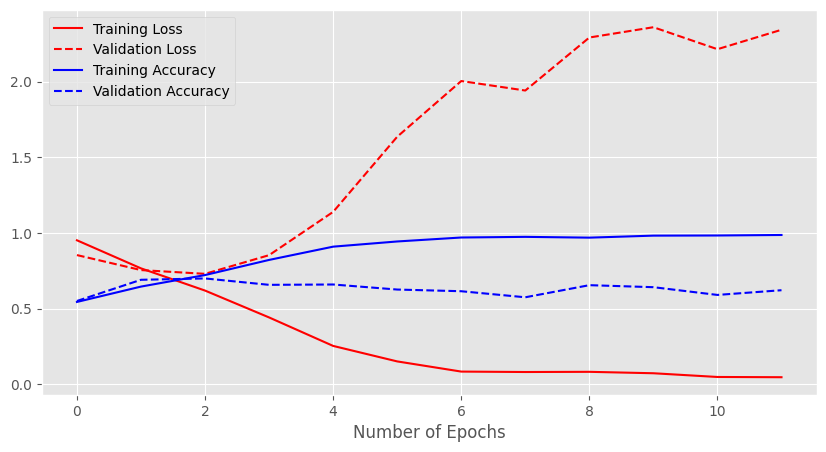

In [ ]:
# plot the error and accuracy
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()